In [1]:
from transformers import AutoModel
from numpy.dtypes import StringDType
from random import randint
import torch
import torch.nn as nn
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
from zootopia3 import MyCNN, simulate_shapes
from sklearn.preprocessing import LabelEncoder

/home/sdtemple/sandboxes/zootopia3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run the following to simulate data

The amount of data simulated is intentionally small to verify the model works on a CPU.

In [ ]:

image_width = 224
image_height = 224
min_x = 10
max_x = 100
num_shape_examples = 2

magnitude = 50
shades = True

shape_names = [
    'diamond',
    'rectangle',
    'triangle',
    'circle',
]

colors_dict = {
    "yellow": (255, 255, 0),
    "blue": (0, 0, 255),
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "purple": (255, 0, 255),
    "cyan": (0, 255, 255),
}

num_color = len(colors_dict)
if shades:
    num_color += 2
num_shape = len(shape_names)

num_each = num_shape_examples * num_color
num_examples = (num_each * num_shape)

# initialize big array
target_color = np.empty(num_examples, dtype=object) # object instead of StringDType
target_shape = np.empty(num_examples, dtype=object) # may have made some version issues when fitting
target_magnitude = np.empty(num_examples, dtype=np.uint8)
target_rgb = np.empty((num_examples,3), dtype=np.uint8)
images = np.zeros(
    (num_examples,
        image_width,
        image_height,
        3,
    ),
    dtype = np.uint8
)

itr = 0

for shape_name in shape_names:

    sim_color, sim_shape, sim_images, sim_rgb, sim_magnitude = simulate_shapes(
        num_shape_examples,
        shape_name,
        image_width,
        image_height,
        min_x,
        max_x,
        colors_dict,
        magnitude,
        shades,
    )

    target_color[itr:itr+num_each] = sim_color
    target_shape[itr:itr+num_each] = sim_shape
    target_magnitude[itr:itr+num_each] = sim_magnitude
    target_rgb[itr:itr+num_each,] = sim_rgb
    images[itr:itr+num_each,] = sim_images

    itr += num_each

In [ ]:
# label encode the targets
# so that the target is numeric
color_encoder = LabelEncoder()
color_encoder.fit(target_color)
y_color = color_encoder.transform(target_color)
y_color = torch.tensor(y_color)

# label encode the targets
# so that the target is numeric
shape_encoder = LabelEncoder()
shape_encoder.fit(target_shape)
y_shape = shape_encoder.transform(target_shape)
y_shape = torch.tensor(y_shape)

In [ ]:
# transform image data to fit the model

# these parameters come from an imagenet study
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
transform_pipeline = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=means, std=stds)
])

# .contiguous() is important for CPU inference
inputs = transform_pipeline(
    torch.from_numpy(images).permute(0,3,1,2).contiguous()
    )

## Run the following to see images you simulated

yellow circle


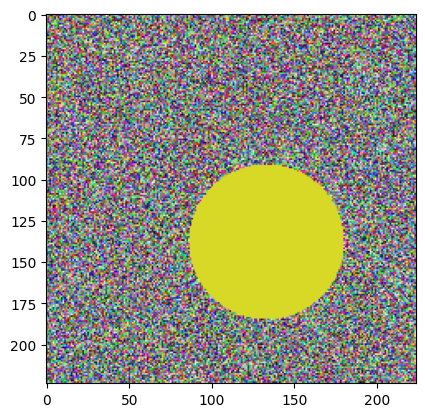

In [8]:
# plot examples
idx = randint(0, num_examples - 1)
print(f'{target_color[idx]} {target_shape[idx]}')
plt.imshow(images[idx])
plt.show()

## Use pretrained model for inference

#### Shape prediction model

In [ ]:
# load the model from hugging face
shape_model = MyCNN.from_pretrained(
    "sdtemple/shape-prediction-model",
    map_location='cpu',
)

In [14]:
print("These are your model inferences")
shape_model(inputs).argmax(axis=1)

These are your model inferences


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
print("These are the true values")
y_shape

These are the true values


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Color prediction model

In [16]:
color_model = MyCNN.from_pretrained(
    "sdtemple/color-prediction-model",
    map_location='cpu',
)

In [17]:
print("These are your model inferences")
color_model(inputs).argmax(axis=1)

These are your model inferences


tensor([7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6,
        7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6,
        7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6])

In [18]:
print("These are the true values")
y_color

These are the true values


tensor([7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6,
        7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6,
        7, 1, 5, 3, 4, 2, 0, 6, 7, 1, 5, 3, 4, 2, 0, 6])